# Inteligencia Artificial
# Clase 8 - Redes Neuronales con Keras

Ya hemos entrenado nuestras primeras redes neuronales implementando el código desde cero con Numpy. Gracias a la existencia de diversos *frameworks* específicos de *deep learning*, típicamente no tendremos que preocuparnos por desarrollarlo todo *from scratch*, sino que trabajaremos con las clases predefinas por alguno de estos *frameworks*. En esta notebook, tendremos nuestro primer contacto con [Keras](https://keras.io/), la API de alto nivel que utilizaremos para desarrollar nuestras redes neuronales a lo largo de todo el curso.

<img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" width=850/>

Por ser una biblioteca de alto nivel, Keras no maneja operaciones de bajo nivel tales como las manipulaciones y deferenciaciones de tensores que están en la base del entrenamiento de una red neuronal. En cambio, depende de algún otro paquete especializado y optimizado en procesamiento de tensores para hacer las operaciones de bajo nivel necesarias. Si bien Keras fue desarrollada para correr sobre múltiples *backends*, como [TensorFlow](https://www.tensorflow.org/), [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) o [Theano](http://deeplearning.net/software/theano/), la sugerencia oficial es trabajar con TensorFlow como *backend*, sugerencia que nosotros respetaremos.

In [0]:
# Comandos necesarios para instalar TensorFlow y Keras en un entorno local
!pip install tensorflow
!pip install keras

In [0]:
# Importamos Keras y comprobamos la versión
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Primera aproximación a una red neuronal con Keras

Ahora vamos a replicar el ejercicio de la clase anterior de entrenar una red neuronal para "aprender" un clasificador capaz de etiquetar dígitos escritos a mano, pero esta vez utilizando Keras.

Volveremos a trabajar con el dataset MNIST, un clásico en la comunidad de *machine learning*. Recordemos que este dataset consiste en un conjunto  de imágenes de dígitos escritos a mano, codificados en una escala de grises, divididos en imágenes de 28 píxels x 28 píxels y etiquetados en 10 posibles categorías (0 a 9). Contamos con 60.000 imágenes de entrenamiento y 10.000 de test.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/>
<center><i>Algunos ejemplos del dataset MNIST</i></center>

El dataset MNIST dataset viene precargado en Keras en objetos de tipo Numpy arrays.

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


`train_images` y `train_labels` conforman el conjunto de entrenamiento, los datos que el modelo va a usar para el aprendizaje. Luego vamos a evaluar el modelo en el conjunto de test, `test_images` y `test_labels`. Nuestras imágenes están codificadas como Numpy arrays, y las labels son arrays de dígitos del 0 al 9. Existe una correspondencia uno a uno entre las imágenes y las labels. 

Veamos los datos de entrenamiento:

In [0]:
type(train_images)

numpy.ndarray

In [0]:
# Veamos la cantidad de dimensiones que tiene el tensor train_images
train_images.ndim

3

In [0]:
train_images.shape

(60000, 28, 28)

In [0]:
train_labels.shape

(60000,)

In [0]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

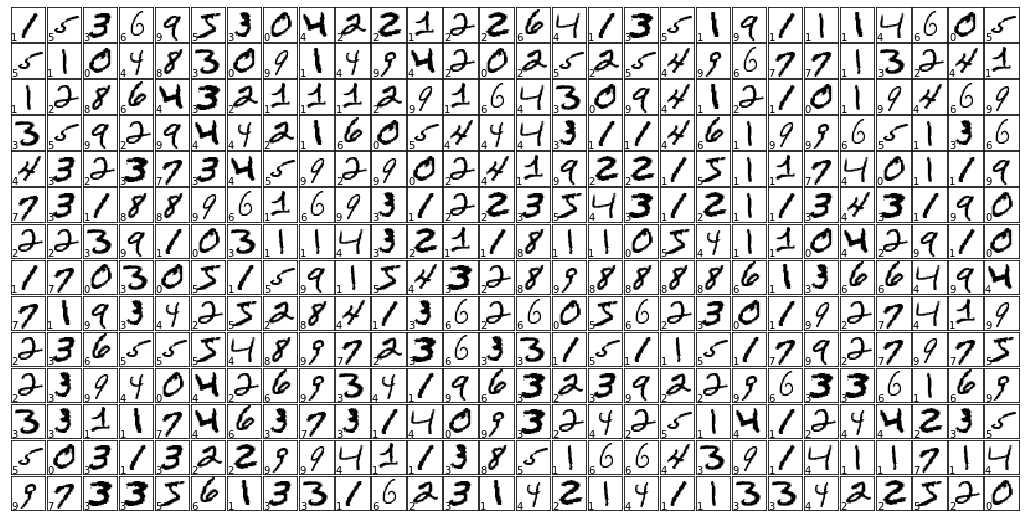

In [0]:
# Visualizamos algunas de las imágenes contenidas en el dataset
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Graficamos algunos dígitos elegidos al azar
for i, j in enumerate(np.random.choice(train_images[0].shape[0], 392)):
    ax = fig.add_subplot(28, 28, i + 1, xticks=[], yticks=[]) # Cada imagen tiene un tamaño de 28 x 28 pixels
    ax.imshow(train_images[j].reshape((28,28)), cmap=plt.cm.binary,
              interpolation='nearest') # imshow permite generar imágenes a partir de arrays de Numpy
    ax.text(0, 27, str(train_labels[j]), fontsize=10) # Etiquetamos cada imagen con el target

Ahora veamos los datos de test:

In [0]:
test_images.shape

(10000, 28, 28)

In [0]:
test_labels.shape

(10000,)

In [0]:
test_labels[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

Las redes que construimos en Numpy la clase pasada tenían la siguiente arquitectura:

- Una capa de *input* de 784 neuronas, una para cada píxel de las imágenes.
- Una capa oculta de 30 unidades, encargada de generar una representación útil de los datos originales.
- Una capa de *output* con 10 neuronas, una para cada clase en el dataset.

La función de activación que utilizamos para todas las neuronas era la sigmoidea.

Vemos a continuación cómo reproducir la misma arquitectura usando la clase de modelo `Sequential` y la clase de capas `Dense` de Keras:

In [0]:
from keras.models import Sequential
from keras.layers import Dense

network = Sequential() # Instanciamos un modelo secuencial

# Añadimos una capa oculta con 30 neuronas, con activación sigmoidea y cuyo input tiene 784 dimensiones
network.add(Dense(30, activation='sigmoid', input_dim=784)) 

# Añadimos una capa de salida con 10 neuronas, con activación sigmoidea
network.add(Dense(10, activation='sigmoid')) # Luego de la primera capa oculta, ya no es necesario especificar las dimensiones del input

¡Fantástico! En muy pocas líneas de código pudimos diseñar la arquitectura de nuestra red neuronal. El método `.summary()` nos permite observar la estructura de la red:

In [0]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                23550     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________


> **¿Cómo explicamos la cantidad de parámetros por capa?** *Hint*: vale la pena recordar la ecuación del *feedforward* para cada capa de una red neuronal: $ a^{l} = \sigma(w^l a^{l-1}+b^l) $

Definida la arquitectura del modelo, el paso siguiente es el de **compilación**, que deja lista la red para ser entrenada. Para poder ejecutar este paso tendremos que elegir tres cosas:

* Una **función de pérdida** que le sirva a la red para evaluar cómo está performando en los datos de entrenamiento y poder calibrar los parámetros en la descripción correcta. Elegiremos la *categorical cross - entropy* como función de costo.

* Una **métrica** para monitorear en train y test. En este caso, vamos a utilizar el **accuracy** (el porcentaje de imágenes que fueron correctamente clasificadas).

* Un **optimizador**, el mecanismo por el cual se actualizan los parámetros de la red en base a la función de pérdida. Básicamente, un optimizador es una variante del algoritmo de *gradient descent*. Por ahora, vamos a optar por el **rmsprop** como optimizador. Más adelante, estudiaremos otras alternativas.

In [0]:
network.compile(loss='categorical_crossentropy',
                metrics=['accuracy'],
                optimizer='rmsprop')

Compilado el modelo, ¡la red ya está lista para entrenar!

Nuestro workflow será el siguiente:

 1. Vamos a presentarle a la red neuronal los datos de entrenamiento `train_images` y `train_labels`. Con esto la red aprenderá a asociar imágenes y *labels*.
 2. Vamos a presentarle a la red las `test_images`.
 3. Vamos a comparar el resultado de las predicciones contra las `test_labels`.

Antes de entrenar, **vamos a preprocesar los datos haciendo un reshape para llevarlos a la forma que la red espera y vamos a reescalarlos para que los valores caigan en el intervalo $[0, 1]$**. Al prinicipio, nuestros datos están almacenados en dimensiones $(60000, 28, 28)$ con valores en el intervalo $[0, 255]$.

In [0]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

También tenemos que codificar categóricamente las etiquetas, de forma de generar un vector de *labels* que luego pueda ser contrastado con el *output* de la red. El método `.to_categorical()` del módulo de utilidades de Keras nos facilita esta tarea:

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [0]:
train_labels.shape

(60000, 10)

In [0]:
train_labels[0:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Ahora estamos listos para entrenar nuestra red, lo cual en Keras se hará vía una llamada al método `.fit()`. Entre otras cosas, deberemos aclarar cuáles son los datos de entrenamiento y sus respectivas etiquetas, por cuántos *epochs* entrenaremos el modelo y el tamaño del *batch*. Si deseamos separar una porción aleatoria de los datos de *train* para validar sobre ellos, podemos hacerlo especificando una proporción con el argumento `validation_split`:

In [0]:
network.fit(train_images, train_labels,
            epochs=5, batch_size=16,
            validation_split=10000/train_images.shape[0])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 5s 93us/step - loss: 0.5811 - accuracy: 0.8665 - val_loss: 0.2627 - val_accuracy: 0.9257
Epoch 2/5
50000/50000 [==============================] - 4s 87us/step - loss: 0.2614 - accuracy: 0.9231 - val_loss: 0.2188 - val_accuracy: 0.9348
Epoch 3/5
50000/50000 [==============================] - 4s 87us/step - loss: 0.2249 - accuracy: 0.9334 - val_loss: 0.1981 - val_accuracy: 0.9415
Epoch 4/5
50000/50000 [==============================] - 4s 87us/step - loss: 0.2028 - accuracy: 0.9408 - val_loss: 0.1876 - val_accuracy: 0.9453
Epoch 5/5
50000/50000 [==============================] - 4s 89us/step - loss: 0.1874 - accuracy: 0.9451 - val_loss: 0.1799 - val_accuracy: 0.9477


Durante el entrenamiento, se presentan dos valores: la *loss* y la métrica de evaluación utilizada (en nuestro caso, el accuracy). Veremos la impresión de los valores obtenidos sobre el set de entrenamiento. Opcionalmente, si estamos trabajando con un set de validación, al final de cada *epoch* también veremos qué valores obtenemos sobre este conjunto de datos.

Luego de entrenar el modelo por tan sólo 5 *epochs*, obtuvimos un accuracy en validación de aproximadamente 95%. Ahora, evaluemos la *performance* del modelo sobre los datos de test usando el método `.evaluate()`:

In [0]:
# evaluate() devuelve los valores de la loss y las métricas definidas en la compilación
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 23us/step


In [0]:
# Llamando al atributo metric_names podemos ver las métricas del modelo, que son el output del método evaluate()
network.metrics_names

['loss', 'accuracy']

In [0]:
print('test_acc:', test_acc)

test_acc: 0.9447000026702881


Nuestro set de test presenta un accuracy un poco más bajo que el de train, como era de esperar. Sin embargo, la diferencia de performance no es sustancial, por lo cual intuimos que no estamos incurriendo en *overfitting*.

Podemos además generar predicciones con el método `.predict()`:

In [0]:
classes = network.predict(test_images)

In [0]:
type(classes)

numpy.ndarray

In [0]:
classes.shape

(10000, 10)

In [0]:
classes[1]

array([8.4164833e-07, 8.2282850e-07, 6.4749718e-03, 9.2747332e-06,
       6.4113331e-10, 3.3401841e-06, 2.6211205e-06, 6.1921128e-08,
       7.0898568e-07, 1.5733457e-09], dtype=float32)

In [0]:
# Con el método argmax() seleccionamos a la clase con mayor probabilidad, es decir la clase predicha por nuestro modelo:
classes[1].argmax()

2

In [0]:
# Verificamos en el set de testeo y corroboramos que la predicción fue correcta:
test_labels[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## ReLU y Softmax

Vimos qué sencillo fue construir y entrenar con Keras la misma red neuronal que desarrollamos íntegramente con Numpy la clase anterior.

Ahora veremos que modificar la función de activación de una capa de neuronas no supone mayores inconvenientes. En particular, reemplazaremos la activación sigmoidea por la ReLU para las unidades ocultas y por la softmax para la capa de salida. Recordemos las fórmulas de estas funciones de activación:

$$ ReLU = \max(0, z) $$

$$ Softmax(z)_i = \frac{\exp(z_i)}{\sum_j\exp(z_j)} $$

Por otra parte, vamos a explorar qué ocurre con la *performance* del modelo cuando trabajamos con una red más grande, con una capa oculta de 512 unidades en lugar de 30.

In [0]:
net = Sequential() # Instanciamos un modelo secuencial

# Añadimos una capa oculta con 512 neuronas, con activación relu y cuyo input tiene 784 dimensiones
net.add(Dense(512, activation='relu', input_dim=784))

# Añadimos una capa de salida con 10 neuronas, con activación softmax
net.add(Dense(10, activation='softmax'))

In [0]:
net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [0]:
net.compile(loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer='rmsprop')

In [0]:
net.fit(train_images, train_labels,
        epochs=5, batch_size=16,
        validation_split=10000/train_images.shape[0])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 14s 283us/step - loss: 0.2134 - accuracy: 0.9372 - val_loss: 0.1267 - val_accuracy: 0.9662
Epoch 2/5
50000/50000 [==============================] - 15s 290us/step - loss: 0.1047 - accuracy: 0.9714 - val_loss: 0.1161 - val_accuracy: 0.9735
Epoch 3/5
50000/50000 [==============================] - 14s 287us/step - loss: 0.0805 - accuracy: 0.9798 - val_loss: 0.1128 - val_accuracy: 0.9754
Epoch 4/5
50000/50000 [==============================] - 14s 283us/step - loss: 0.0670 - accuracy: 0.9836 - val_loss: 0.1164 - val_accuracy: 0.9761
Epoch 5/5
50000/50000 [==============================] - 14s 283us/step - loss: 0.0555 - accuracy: 0.9866 - val_loss: 0.1297 - val_accuracy: 0.9778


Con esta red, rápidamente alcanzamos un accuracy por encima del 98% sobre los datos de entrenamiento. Ahora veamos cómo se desempeña el modelo sobre datos de test:

In [0]:
test_loss, test_acc = net.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 44us/step


In [0]:
print('test_acc:', test_acc)

test_acc: 0.9775999784469604


¡Excelente! Incrementando la capacidad de representación de nuestra red pudimos mejorar su capacidad predictiva sin caer en *overfitting*.

Generemos predicciones con esta segunda red:

In [0]:
classes = net.predict(test_images)

In [0]:
classes[1]

array([1.0402490e-21, 2.2033157e-14, 1.0000000e+00, 6.1688677e-15,
       0.0000000e+00, 7.8401092e-17, 1.0465284e-16, 0.0000000e+00,
       1.1189215e-16, 0.0000000e+00], dtype=float32)

In [0]:
# Con el método argmax() seleccionamos a la clase con mayor probabilidad, es decir la clase predicha por nuestro modelo:
classes[1].argmax()

2

In [0]:
# Verificamos en el set de testeo y corroboramos que la predicción fue correcta:
test_labels[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
# Por último, verificamos que la suma de las probabilidades del softmax den 1:
classes[1].sum()

1.0

## Recapitulando

Hemos tenido nuestro primer contacto con Keras. Vimos que es posible desarrollar un clasificador de las imágenes del MNIST que obtiene un accuracy en *test* de casi 98%... ¡con menos de 10 líneas de código!

Los puntos claves que debemos llevarnos de esta notebook son:

- La clase `Sequential` del módulo `models` de Keras nos permite instanciar una red secuencial, el molde sobre el que construiremos la arquitectura de la red.
- Podemos "apilar" capas en el modelo secuencial añadiéndolas con el método `.add()`.
- La clase `Dense` del módulo de `layers` nos permite incorporar a la red capas *fully - connected* o densamente conectadas (de ahí el nombre de la clase).
- Siempre que agreguemos una capa, debemos especificar su cantidad de neuronas y la correspondiente función de activación. Sólo en el caso de la primera capa oculta tendremos que aclarar las dimensiones del *input*.
- Antes de poder entrenar, debemos compilar nuestra red con el método `.compile()`. En este paso, debemos definir una función de pérdida, una o más métricas de evaluación y el optimizador de la red.
- El método `.fit()` permite el ajuste de la red a los datos. En esta instancia, además de especificar cuál es el conjunto de entrenamiento, tendremos que definir la cantidad de *epochs* y el tamaño del *batch*. Optativamente, podemos definir si queremos trabajar con un conjunto de datos de validación.
- `evaluate()` permite evaluar el modelo sobre un conjunto de datos de testeo. Este método retorna las métricas de evaluación y el valor de la función de costo que se obtienen sobre el set de *test*.
- `predict()` nos permite obtener las predicciones que la red genera para un conjunto de datos de entrada en particular.